In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from url_years import urls

all_data = []

for year, url in urls.items():
    print(f'procesando{year}...')
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        ball = soup.find_all('li', class_='ball ball -b280')
        powerball = soup.find_all('li', class_='ball powerball -b280')
        draw = soup.find_all('td', class_='noBefore colour date-row')


        for i in range(0, len(ball), 7):
            bloque_numeros = ball[i:i+7]        
            numeros = [q.text for q in bloque_numeros]

            PW = powerball[i // 7].text if (i // 7) < len(powerball) else "Powerball Desconocida"
            DR = draw[i // 7].text.strip() if (i // 7) < len(draw) else "Draw is missing"

            
            registro = {
                'Sorteo': DR,
                'Powerball': PW,
                'Year': year
            }

            
            for idx, num in enumerate(numeros, start=1):
                registro[f'Numero{idx}'] = num

            all_data.append(registro)
   
    
    else:
        print(f'Error al acceder a la pagina {url}')

df = pd.DataFrame(all_data)

cols = df.columns.tolist()
cols.remove('Powerball')
cols.append('Powerball')
df = df[cols]

df['Numero de Sorteo'] = df['Sorteo'].str.extract(r'([\d,]+)')
df['Fecha'] = df['Sorteo'].str.extract(r'\d+(\w+\s\d{1,2}\s\w+\s\d{4})')
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df = df.drop(columns=['Sorteo'])

#df.to_excel('C:/Users/jessi/OneDrive/Desktop/df_lotto_prueba_final.xlsx', index=False)

procesando2025...
procesando2024...
procesando2023...
procesando2022...
procesando2021...
procesando2020...
procesando2019...
procesando2018...
procesando2017...
procesando2016...
procesando2015...
procesando2014...
procesando2013...
procesando2012...
procesando2011...
procesando2010...
procesando2009...
procesando2008...
procesando2007...
procesando2006...
procesando2005...
procesando2004...
procesando2003...
procesando2002...
procesando2001...
procesando2000...
procesando1999...
procesando1998...
procesando1997...
procesando1996...


In [10]:
columnas_numeros = ["Numero1","Numero2","Numero3","Numero4","Numero5","Numero6","Numero7","Powerball"]
df = df.sort_values("Fecha")
df = df.reset_index(drop=True)
for col in columnas_numeros:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[columnas_numeros] = df[columnas_numeros].fillna(0)
df[columnas_numeros] = df[columnas_numeros].astype(int)
display(df.head(10))
display(df.dtypes)

,Year,Numero1,Numero2,Numero3,Numero4,Numero5,Numero6,Numero7,Powerball,Numero de Sorteo,Fecha
0,1996,44,2,8,27,30,42,0,24,10,1996-07-25
1,1996,33,36,40,6,8,15,23,32,11,1996-08-01
2,1996,25,37,40,42,43,4,32,7,12,1996-08-08
3,1996,35,41,3,15,30,33,39,17,13,1996-08-15
4,1996,7,12,16,34,1,3,10,4,14,1996-08-22
5,1996,43,14,26,28,38,40,3,4,15,1996-08-29
6,1996,11,23,43,9,12,14,23,35,16,1996-09-05
7,1996,2,19,25,30,36,4,9,33,17,1996-09-12
8,1996,33,42,22,25,36,41,44,34,18,1996-09-19
9,1996,8,9,24,42,7,14,22,17,19,1996-09-26


Year                         int64
Numero1                      int64
Numero2                      int64
Numero3                      int64
Numero4                      int64
Numero5                      int64
Numero6                      int64
Numero7                      int64
Powerball                    int64
Numero de Sorteo             int64
Fecha               datetime64[ns]
dtype: object

Versión A → Próximo sugerido desde entrada: [8, 41, 12, 18, 1, 7, 30] | PB: 15
Versión B → Próximo sugerido desde el último sorteo: [6, 8, 12, 14, 17, 26, 35] | PB: 4


Versión A → Próximo sugerido desde entrada: [8, 41, 12, 18, 1, 7, 30] | PB: 15
Versión B → Próximo sugerido desde el último sorteo: [6, 8, 12, 14, 17, 26, 35] | PB: 4


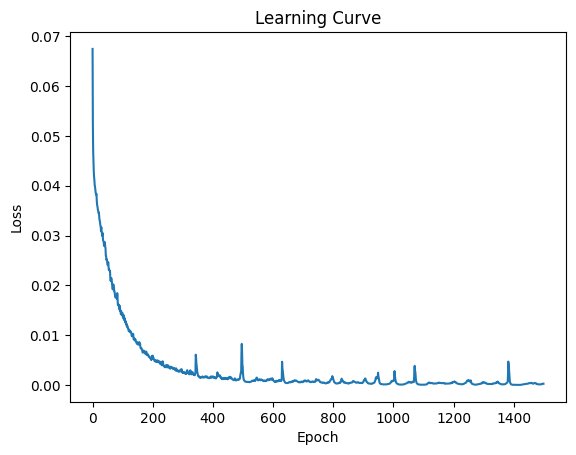

In [20]:
# pip install tensorflow --upgrade
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# ======== 1) Preparar datos ========
num_cols = [f"Numero{i}" for i in range(1, 8)] + ["Powerball"]
df_nums = df[num_cols].copy().reset_index(drop=True)

# Convertir a enteros
for c in num_cols:
    df_nums[c] = pd.to_numeric(df_nums[c], errors="coerce")
df_nums = df_nums.dropna(subset=num_cols).astype(int).reset_index(drop=True)

# Pares alternos
X_rows = df_nums.iloc[::2].copy()
Y_rows = df_nums.iloc[1::2].copy()
m = min(len(X_rows), len(Y_rows))
X_rows, Y_rows = X_rows.iloc[:m].reset_index(drop=True), Y_rows.iloc[:m].reset_index(drop=True)

X_np, Y_np = X_rows.values.astype(np.float32), Y_rows.values.astype(np.float32)

# Escalado MinMax
both = np.vstack([X_np, Y_np])
col_max, col_min = both.max(axis=0).clip(min=1.0), both.min(axis=0)

def minmax_scale(a, cmin, cmax):
    return (a - cmin) / (cmax - cmin + 1e-8)

def minmax_inverse(a_scaled, cmin, cmax):
    return a_scaled * (cmax - cmin + 1e-8) + cmin

X_sc, Y_sc = minmax_scale(X_np, col_min, col_max), minmax_scale(Y_np, col_min, col_max)

# ======== 2) Definir modelo en TensorFlow ========
model = models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(500, activation="relu"),
    layers.Dense(250, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(8, activation="sigmoid")  # salida 0-1
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="mse")

# ======== 3) Entrenamiento ========
history = model.fit(X_sc, Y_sc, epochs=1500, batch_size=32, shuffle=True, verbose=0)

# ======== 4) Helpers ========
def postprocess_prediction(vec_float):
    real_col_max = df_nums[num_cols].max().values
    real_col_min = df_nums[num_cols].min().values

    pred = np.rint(vec_float).astype(int)

    for i in range(8):
        lo, hi = int(real_col_min[i]), int(real_col_max[i])
        pred[i] = np.clip(pred[i], lo, hi)

    main, pb = pred[:7], int(pred[7])

    # Asegurar unicidad en los 7 principales
    seen = set()
    for i in range(len(main)):
        while main[i] in seen:
            main[i] = min(main[i] + 1, int(real_col_max[i]))
        seen.add(main[i])

    return main.tolist(), pb

def predict_from_input(nums7_plus_pb):
    arr = np.array(nums7_plus_pb, dtype=np.float32).reshape(1, -1)
    arr_sc = minmax_scale(arr, col_min, col_max)
    out_sc = model.predict(arr_sc, verbose=0)
    out_real = minmax_inverse(out_sc, col_min, col_max)[0]
    return postprocess_prediction(out_real)

def predict_from_last_draw():
    last = df_nums.iloc[-1][num_cols].values.astype(np.float32).reshape(1, -1)
    last_sc = minmax_scale(last, col_min, col_max)
    out_sc = model.predict(last_sc, verbose=0)
    out_real = minmax_inverse(out_sc, col_min, col_max)[0]
    return postprocess_prediction(out_real)

# ======== 5) Ejemplo ========
entrada_usuario = [5, 12, 23, 34, 45, 48, 52, 15]
nums_pred, pb_pred = predict_from_input(entrada_usuario)
print("Versión A → Próximo sugerido desde entrada:", nums_pred, "| PB:", pb_pred)

nums_pred2, pb_pred2 = predict_from_last_draw()
print("Versión B → Próximo sugerido desde el último sorteo:", nums_pred2, "| PB:", pb_pred2)

# ======== 6) Graficar curva de pérdida ========
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()


In [ ]:
# pip install torch --upgrade
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ======== 1) Preparar datos ========
# Asegúrate de que estas columnas existan y sean int
num_cols = [f"Numero{i}" for i in range(1, 8)] + ["Powerball"]
df_nums = df[num_cols].copy()

# (Opcional) ordena cronológicamente si no lo está
# df_nums = df_nums.sort_values("Fecha")  # o por "Numero de Sorteo" si es confiable
df_nums = df_nums.reset_index(drop=True)

# Convertir a enteros por si quedaron floats
for c in num_cols:
    # Si hay NaN, puedes decidir: rellenar o drop. Aquí dropeamos filas con NaN.
    df_nums[c] = pd.to_numeric(df_nums[c], errors="coerce")
df_nums = df_nums.dropna(subset=num_cols).astype(int).reset_index(drop=True)

# Armar pares alternos: X = 1,3,5,...   Y = 2,4,6,...
X_rows = df_nums.iloc[::2].copy()
Y_rows = df_nums.iloc[1::2].copy()
# Alinear longitudes (por si hay impar)
m = min(len(X_rows), len(Y_rows))
X_rows = X_rows.iloc[:m].reset_index(drop=True)
Y_rows = Y_rows.iloc[:m].reset_index(drop=True)

X_np = X_rows.values.astype(np.float32)
Y_np = Y_rows.values.astype(np.float32)

# Escalado MinMax por columna (para no asumir rangos fijos)
col_max = X_np.max(axis=0).clip(min=1.0)  # evitar división por 0
col_min = X_np.min(axis=0)

# Usamos minmax sobre todo el conjunto (X e Y) para coherencia:
both = np.vstack([X_np, Y_np])
col_max = both.max(axis=0).clip(min=1.0)
col_min = both.min(axis=0)

def minmax_scale(a, cmin, cmax):
    return (a - cmin) / (cmax - cmin + 1e-8)

def minmax_inverse(a_scaled, cmin, cmax):
    return a_scaled * (cmax - cmin + 1e-8) + cmin

X_sc = minmax_scale(X_np, col_min, col_max)
Y_sc = minmax_scale(Y_np, col_min, col_max)

X_t = torch.tensor(X_sc, dtype=torch.float32)
Y_t = torch.tensor(Y_sc, dtype=torch.float32)

dataset = TensorDataset(X_t, Y_t)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ======== 2) Definir modelo ========
class MLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),  # Nueva capa de 128 neuronas
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),   # Nueva capa de 64 neuronas
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()  # salidas 0-1 por el minmax
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=8, output_dim=8)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======== 3) Entrenamiento ========
epochs = 1500
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(xb)
    # if (epoch+1) % 25 == 0:
    #     print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(dataset):.6f}")

# ======== 4) Helpers para post-proceso ========
def postprocess_prediction(vec_float, main_max=None, pb_max=None):
    """
    vec_float: array de 8 valores (7 números + 1 powerball) en escala real (no minmax).
    - Redondea a enteros
    - Clampa a rangos (según histórico)
    - Devuelve (nums7, pb) en el orden original
    """
    # Estimar rangos por columna a partir del histórico:
    # Usamos min y max de cada col histórica.
    real_col_max = df_nums[num_cols].max().values
    real_col_min = df_nums[num_cols].min().values

    pred = np.rint(vec_float).astype(int)

    # Clamp columna a columna
    for i in range(8):
        lo = int(real_col_min[i])
        hi = int(real_col_max[i])
        pred[i] = np.clip(pred[i], lo, hi)

    # 7 primeros en el orden original y última es Powerball
    main = pred[:7]
    pb = int(pred[7])

    # Si quieres asegurar unicidad en los 7 principales, puedes forzar:
    # (resuelve empates incrementando dentro del rango permitido)
    seen = set()
    for i in range(len(main)):
        while main[i] in seen:
            main[i] = min(main[i] + 1, int(real_col_max[i]))
        seen.add(main[i])

    return main.tolist(), pb

def predict_from_input(nums7_plus_pb):
    """
    Versión A: El usuario mete 7 números + powerball, y el modelo devuelve un "siguiente".
    """
    arr = np.array(nums7_plus_pb, dtype=np.float32).reshape(1, -1)
    arr_sc = minmax_scale(arr, col_min, col_max)
    model.eval()
    with torch.no_grad():
        out_sc = model(torch.tensor(arr_sc, dtype=torch.float32)).numpy()
    out_real = minmax_inverse(out_sc, col_min, col_max)[0]
    return postprocess_prediction(out_real)

def predict_from_last_draw():
    """
    Versión B: usa el último sorteo del histórico y predice el siguiente.
    Si tu histórico termina en un índice par (usaste pares alternos),
    igualmente tomamos el último registro disponible.
    """
    last = df_nums.iloc[-1][num_cols].values.astype(np.float32).reshape(1, -1)
    last_sc = minmax_scale(last, col_min, col_max)
    model.eval()
    with torch.no_grad():
        out_sc = model(torch.tensor(last_sc, dtype=torch.float32)).numpy()
    out_real = minmax_inverse(out_sc, col_min, col_max)[0]
    return postprocess_prediction(out_real)

# ======== 5) Ejemplos de uso ========
# A) Entrada manual
entrada_usuario = [5, 12, 23, 34, 45, 48, 52, 15]  # 7 + PB (ejemplo)
nums_pred, pb_pred = predict_from_input(entrada_usuario)
print("Versión A → Próximo sugerido desde entrada:", nums_pred, "| PB:", pb_pred)

# B) Usando el último sorteo real
nums_pred2, pb_pred2 = predict_from_last_draw()
print("Versión B → Próximo sugerido desde el último sorteo del histórico:",
      nums_pred2, "| PB:", pb_pred2)

Versión A → Próximo sugerido desde entrada: [16, 29, 8, 17, 20, 18, 30] | PB: 15
Versión B → Próximo sugerido desde el último sorteo del histórico: [3, 7, 13, 18, 23, 27, 32] | PB: 10


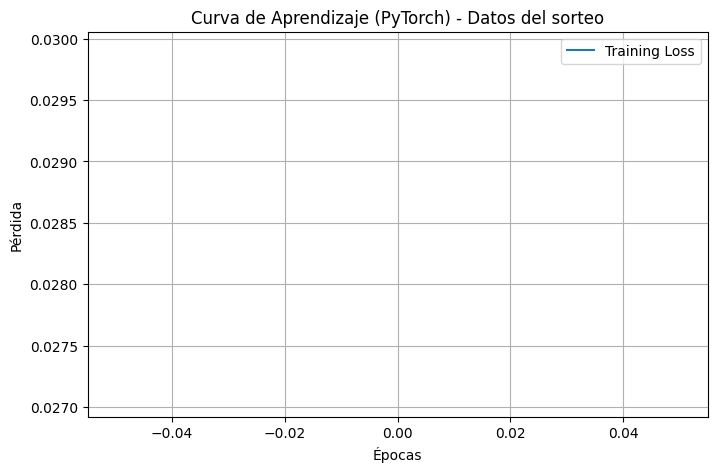

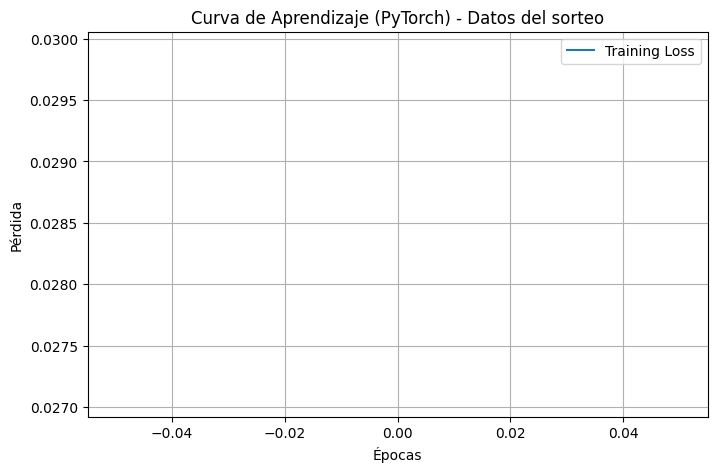

Época 1/150, Pérdida entrenamiento: 0.0285
Época 2/150, Pérdida entrenamiento: 0.0282
Época 2/150, Pérdida entrenamiento: 0.0282
Época 3/150, Pérdida entrenamiento: 0.0279
Época 3/150, Pérdida entrenamiento: 0.0279
Época 4/150, Pérdida entrenamiento: 0.0279
Época 4/150, Pérdida entrenamiento: 0.0279
Época 5/150, Pérdida entrenamiento: 0.0281
Época 5/150, Pérdida entrenamiento: 0.0281
Época 6/150, Pérdida entrenamiento: 0.0280
Época 6/150, Pérdida entrenamiento: 0.0280
Época 7/150, Pérdida entrenamiento: 0.0278
Época 7/150, Pérdida entrenamiento: 0.0278
Época 8/150, Pérdida entrenamiento: 0.0278
Época 8/150, Pérdida entrenamiento: 0.0278
Época 9/150, Pérdida entrenamiento: 0.0278
Época 9/150, Pérdida entrenamiento: 0.0278
Época 10/150, Pérdida entrenamiento: 0.0278
Época 10/150, Pérdida entrenamiento: 0.0278
Época 11/150, Pérdida entrenamiento: 0.0278
Época 11/150, Pérdida entrenamiento: 0.0278
Época 12/150, Pérdida entrenamiento: 0.0277
Época 12/150, Pérdida entrenamiento: 0.0277
Época

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Usar el modelo y loader definidos en la celda anterior
# loader = DataLoader(dataset, batch_size=32, shuffle=True)
# model = MLP(input_dim=8, output_dim=8)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = epochs
train_losses = []

plt.ion()
fig, ax = plt.subplots(figsize=(8,5))

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(xb)
    train_losses.append(running_loss / len(loader.dataset))

    # Actualizar gráfica en cada época
    ax.clear()
    ax.plot(train_losses, label="Training Loss")
    ax.set_title("Curva de Aprendizaje (PyTorch) - Datos del sorteo")
    ax.set_xlabel("Épocas")
    ax.set_ylabel("Pérdida")
    ax.legend()
    ax.grid(True)
    plt.pause(0.1)

    print(f"Época {epoch+1}/{num_epochs}, "
          f"Pérdida entrenamiento: {train_losses[-1]:.4f}")

plt.ioff()
plt.show()